In [13]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


random.seed(42)
import warnings
warnings.filterwarnings("ignore")
os.chdir(r'C:\Users\Machine Learning GPU\Desktop\App')

In [2]:
pip install Flask

In [4]:
import flask

In [14]:
n_cpu = 0
hr_height = 256
hr_width = 256
channels = 3
lr = 0.0001
b1 = 0.5
b2 = 0.999
cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

In [15]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [16]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out
    

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)
    
input_shape = (3, 64, 64)


In [18]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

generator.load_state_dict(torch.load(r"C:\Users\Machine Learning GPU\Desktop\App\saved_models\generator.pth"))
discriminator.load_state_dict(torch.load(r"C:\Users\Machine Learning GPU\Desktop\App\saved_models\discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [19]:
def to_np(x):
    return x.data.cpu().numpy()

SRGAN - SSIM: 0.9345 ± 0.0431, PSNR: 35.1998 ± 3.3081 dB
Bicubic - SSIM: 0.9429 ± 0.0527, PSNR: 38.3370 ± 5.2724 dB
Bilinear - SSIM: 0.9274 ± 0.0632, PSNR: 36.5431 ± 4.9702 dB


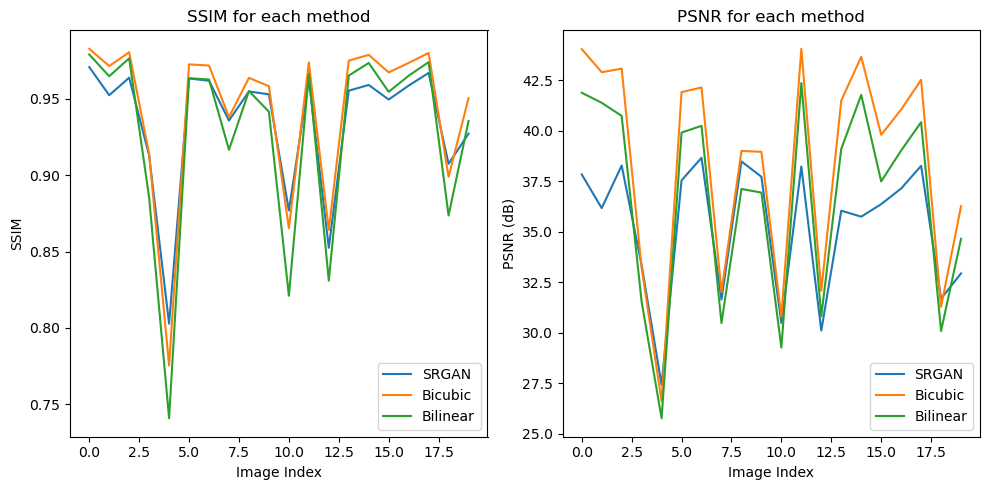

In [20]:
count = 0
val_path = r"C:/Users/Machine Learning GPU/Desktop/App/Testset_20_LR/"
os.makedirs('val_outputs', exist_ok=True)

generator.eval()

ssim_values_sr = []
psnr_values_sr = []
ssim_values_bicubic = []
psnr_values_bicubic = []
ssim_values_bilinear = []
psnr_values_bilinear = []

def denormalize(tensor):
    return ((tensor + 1) * 127.5).clamp(0, 255).byte()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[127.5 / 255.0], std=[127.5 / 255.0])
])

for img in os.listdir(val_path):
    imgs_hr = Image.open(os.path.join(val_path, img)).convert("RGB")
    imgs_hr = imgs_hr.resize((256, 256), Image.BICUBIC)
    
    imgs_lr = imgs_hr.resize((64, 64), Image.BICUBIC)
    
    imgs_bicubic = imgs_lr.resize((256, 256), Image.BICUBIC)
    imgs_bilinear = imgs_lr.resize((256, 256), Image.BILINEAR)
    
    imgs_hr_tensor = transform(imgs_hr).unsqueeze(0).cuda()
    imgs_lr_tensor = transform(imgs_lr).unsqueeze(0).cuda()
    
    gen_hr = generator(imgs_lr_tensor)
    
    imgs_hr_np = denormalize(imgs_hr_tensor).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
    gen_hr_np = denormalize(gen_hr).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
    
    imgs_bicubic_np = denormalize(transform(imgs_bicubic).unsqueeze(0)).squeeze(0).numpy().transpose(1, 2, 0)
    imgs_bilinear_np = denormalize(transform(imgs_bilinear).unsqueeze(0)).squeeze(0).numpy().transpose(1, 2, 0)
    
    ssim_values_sr.append(ssim(imgs_hr_np, gen_hr_np, multichannel=True, data_range=255))
    psnr_values_sr.append(psnr(imgs_hr_np, gen_hr_np, data_range=255))
    
    ssim_values_bicubic.append(ssim(imgs_hr_np, imgs_bicubic_np, multichannel=True, data_range=255))
    psnr_values_bicubic.append(psnr(imgs_hr_np, imgs_bicubic_np, data_range=255))
    
    ssim_values_bilinear.append(ssim(imgs_hr_np, imgs_bilinear_np, multichannel=True, data_range=255))
    psnr_values_bilinear.append(psnr(imgs_hr_np, imgs_bilinear_np, data_range=255))
    
    save_image(gen_hr, f"val_outputs/{count}.png", normalize=True)
    save_image(imgs_hr_tensor, f"val_outputs/{count}_hr.png", normalize=True)
    count += 1

metrics = {
    "SRGAN": (ssim_values_sr, psnr_values_sr),
    "Bicubic": (ssim_values_bicubic, psnr_values_bicubic),
    "Bilinear": (ssim_values_bilinear, psnr_values_bilinear),
}

for method, (ssim_vals, psnr_vals) in metrics.items():
    avg_ssim = np.mean(ssim_vals)
    std_ssim = np.std(ssim_vals)
    avg_psnr = np.mean(psnr_vals)
    std_psnr = np.std(psnr_vals)
    print(f"{method} - SSIM: {avg_ssim:.4f} ± {std_ssim:.4f}, PSNR: {avg_psnr:.4f} ± {std_psnr:.4f} dB")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ssim_values_sr, label="SRGAN")
plt.plot(ssim_values_bicubic, label="Bicubic")
plt.plot(ssim_values_bilinear, label="Bilinear")
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.title("SSIM for each method")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(psnr_values_sr, label="SRGAN")
plt.plot(psnr_values_bicubic, label="Bicubic")
plt.plot(psnr_values_bilinear, label="Bilinear")
plt.xlabel("Image Index")
plt.ylabel("PSNR (dB)")
plt.title("PSNR for each method")
plt.legend()

plt.tight_layout()
plt.show()
